# 제품 이상여부 판별 프로젝트

## 1. 데이터 불러오기

### 필수 라이브러리

In [336]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [337]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

### 엑셀 파일을 읽는 함수

읽어오는 속도가 느린 엑셀 파일을 위해 csv 파일로 변환하여 저장해 두고 사용합니다.

In [338]:
def read_excel_file(file_path: str, header: int = None) -> pd.DataFrame:
    csv_file = file_path.replace(".xlsx", ".csv")

    if not os.path.exists(csv_file):
        print("Converting excel to csv...")
        if header:
            df = pd.read_excel(file_path, header=header)
        else:
            df = pd.read_excel(file_path)

        df.to_csv(csv_file, index=False)
        print(f"  {file_path} -> {csv_file}")
        return df
    else:
        print(f"  Reading {csv_file}")
        return pd.read_csv(csv_file, low_memory=False)

### 엑셀 파일들 읽어오기

In [339]:
ROOT_DIR = "data"
RANDOM_STATE = 110

X_Dam = read_excel_file(os.path.join(ROOT_DIR, "Dam dispensing.xlsx"), header=1)

X_AutoClave = read_excel_file(
    os.path.join(ROOT_DIR, "Auto clave.xlsx"), header=1
)

X_Fill1 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill1 dispensing.xlsx"), header=1
)

X_Fill2 = read_excel_file(
    os.path.join(ROOT_DIR, "Fill2 dispensing.xlsx"), header=1
)

y = pd.read_csv(os.path.join(ROOT_DIR, "train_y.csv"))

  Reading data/Dam dispensing.csv
  Reading data/Auto clave.csv
  Reading data/Fill1 dispensing.csv
  Reading data/Fill2 dispensing.csv


In [6]:
x = pd.read_excel('./data/Dam dispensing.xlsx')
for i,column in enumerate(x.columns):
    print(i,len(x.loc[1:,column].unique()),column,x.loc[0,column])

Collect Item: Wip Line
Unnamed: 1 Process Desc.
Unnamed: 2 Equipment
Unnamed: 3 Model.Suffix
Unnamed: 4 Workorder
Unnamed: 5 LOT ID
Unnamed: 6 Set ID
Unnamed: 7 Box ID
Unnamed: 8 Collect Date
Unnamed: 9 Insp. Seq No.
Unnamed: 10 Insp Judge Code
CURE END POSITION X Collect Result
CURE END POSITION X.1 Unit Time
CURE END POSITION X.2 Judge Value
CURE END POSITION Z Collect Result
CURE END POSITION Z.1 Unit Time
CURE END POSITION Z.2 Judge Value
CURE END POSITION Θ Collect Result
CURE END POSITION Θ.1 Unit Time
CURE END POSITION Θ.2 Judge Value
CURE SPEED Collect Result
CURE SPEED.1 Unit Time
CURE SPEED.2 Judge Value
CURE STANDBY POSITION X Collect Result
CURE STANDBY POSITION X.1 Unit Time
CURE STANDBY POSITION X.2 Judge Value
CURE STANDBY POSITION Z Collect Result
CURE STANDBY POSITION Z.1 Unit Time
CURE STANDBY POSITION Z.2 Judge Value
CURE STANDBY POSITION Θ Collect Result
CURE STANDBY POSITION Θ.1 Unit Time
CURE STANDBY POSITION Θ.2 Judge Value
CURE START POSITION X Collect Result
CU

0 1 Collect Item: Wip Line
1 1 Unnamed: 1 Process Desc.
2 2 Unnamed: 2 Equipment
3 8 Unnamed: 3 Model.Suffix
4 679 Unnamed: 4 Workorder
5 59271 Unnamed: 5 LOT ID
6 59271 Unnamed: 6 Set ID
7 1 Unnamed: 7 Box ID
8 62479 Unnamed: 8 Collect Date
9 4 Unnamed: 9 Insp. Seq No.
10 1 Unnamed: 10 Insp Judge Code
11 4 CURE END POSITION X Collect Result
12 1 CURE END POSITION X.1 Unit Time
13 1 CURE END POSITION X.2 Judge Value
14 3 CURE END POSITION Z Collect Result
15 1 CURE END POSITION Z.1 Unit Time
16 1 CURE END POSITION Z.2 Judge Value
17 2 CURE END POSITION Θ Collect Result
18 1 CURE END POSITION Θ.1 Unit Time
19 1 CURE END POSITION Θ.2 Judge Value
20 7 CURE SPEED Collect Result
21 1 CURE SPEED.1 Unit Time
22 1 CURE SPEED.2 Judge Value
23 1 CURE STANDBY POSITION X Collect Result
24 1 CURE STANDBY POSITION X.1 Unit Time
25 1 CURE STANDBY POSITION X.2 Judge Value
26 1 CURE STANDBY POSITION Z Collect Result
27 1 CURE STANDBY POSITION Z.1 Unit Time
28 1 CURE STANDBY POSITION Z.2 Judge Value
29 

221 3 Unnamed: 221 nan


In [165]:
X_Dam.columns[62]

'Collect Result.17'

In [101]:
X_Dam['Collect Result.16'].value_counts()

Collect Result.16
0.67    15728
0.92    10273
1.49     8845
1.19     7683
1.45     4159
1.61     3708
1.02     3616
0.91     2629
0.99     1315
1.44     1095
1.00      754
0.95      600
1.62      470
1.03      434
0.96      369
1.48      271
0.94      266
0.81      174
1.56       49
0.80       16
1.57       14
0.68       11
Name: count, dtype: int64

In [281]:
s = pd.read_excel('./data/Fill1 dispensing.xlsx')

In [282]:
for i,column in enumerate(s.columns):
    print(i,len(s.loc[1:,column].unique()),column,s.loc[0,column])

0 1 Collect Item: Wip Line
1 1 Unnamed: 1 Process Desc.
2 2 Unnamed: 2 Equipment
3 7 Unnamed: 3 Model.Suffix
4 665 Unnamed: 4 Workorder
5 58808 Unnamed: 5 LOT ID
6 58808 Unnamed: 6 Set ID
7 1 Unnamed: 7 Box ID
8 61927 Unnamed: 8 Collect Date
9 4 Unnamed: 9 Insp. Seq No.
10 1 Unnamed: 10 Insp Judge Code
11 4 DISCHARGED SPEED OF RESIN Collect Result
12 1 DISCHARGED SPEED OF RESIN.1 Unit Time
13 1 DISCHARGED SPEED OF RESIN.2 Judge Value
14 16 DISCHARGED TIME OF RESIN(Stage1) Collect Result
15 1 DISCHARGED TIME OF RESIN(Stage1).1 Unit Time
16 1 DISCHARGED TIME OF RESIN(Stage1).2 Judge Value
17 24 DISCHARGED TIME OF RESIN(Stage2) Collect Result
18 1 DISCHARGED TIME OF RESIN(Stage2).1 Unit Time
19 1 DISCHARGED TIME OF RESIN(Stage2).2 Judge Value
20 16 DISCHARGED TIME OF RESIN(Stage3) Collect Result
21 1 DISCHARGED TIME OF RESIN(Stage3).1 Unit Time
22 1 DISCHARGED TIME OF RESIN(Stage3).2 Judge Value
23 16 Dispense Volume(Stage1) Collect Result
24 1 Dispense Volume(Stage1).1 Unit Time
25 1 Dis

In [283]:
X_Fill1.columns[32]

'Collect Result.7'

In [284]:
X_Fill1['Collect Result.7'].value_counts()

Collect Result.7
OK       16966
838.4    12020
837.9     7809
837.7     5586
838.2      417
837.5        4
Name: count, dtype: int64

In [331]:
X_Fill1.iloc[25830:25838,[2,3,4,5,6,7,8,32]]

,Equipment - Fill1,Model.Suffix - Fill1,Workorder - Fill1,LOT ID - Fill1,Set ID,Box ID - Fill1,Collect Date - Fill1,Collect Result.7 - Fill1
25830,Fill1 dispenser #2,AJX75334502,3K1X9887-1,OP753345023090001280,OP753345023090001280,NaN,2023-09-28 20:04:21,837.7
25831,Fill1 dispenser #1,AJX75334502,3K1X9887-1,OP753345023090001281,OP753345023090001281,NaN,2023-09-28 20:05:37,838.4
25832,Fill1 dispenser #2,AJX75334502,3K1X9887-1,OP753345023090001282,OP753345023090001282,NaN,2023-09-28 20:06:55,837.7
25833,Fill1 dispenser #1,AJX75334502,3K1X9887-1,OP753345023090001283,OP753345023090001283,NaN,2023-09-28 20:08:11,838.4
25834,Fill1 dispenser #2,AJX75334502,3K1X9887-1,OP753345023090001284,OP753345023090001284,NaN,2023-09-28 20:09:29,837.7
25835,Fill1 dispenser #1,AJX75334502,3K1X9887-1,OP753345023090001285,OP753345023090001285,NaN,2023-09-28 20:10:46,838.4
25836,Fill1 dispenser #1,AJX75334502,3K1X9887-1,OP753345023090001286,OP753345023090001286,NaN,2023-10-02 07:59:33,NaN
25837,Fill1 dispenser #2,AJX75334502,3K1X9887-1,OP753345023090001287,OP753345023090001287,NaN,2023-10-02 08:00:55,NaN


In [190]:
z = pd.read_excel('./data/Auto clave.xlsx')
for i,column in enumerate(z.columns):
    print(i,len(z.loc[1:,column].unique()),column,z.loc[0,column])

0 1 Collect Item: Wip Line
1 1 Unnamed: 1 Process Desc.
2 1 Unnamed: 2 Equipment
3 8 Unnamed: 3 Model.Suffix
4 677 Unnamed: 4 Workorder
5 58317 Unnamed: 5 LOT ID
6 58317 Unnamed: 6 Set ID
7 1 Unnamed: 7 Box ID
8 8766 Unnamed: 8 Collect Date
9 4 Unnamed: 9 Insp. Seq No.
10 1 Unnamed: 10 Insp Judge Code
11 28 1st Pressure Collect Result
12 11 1st Pressure.1 Unit Time
13 1 1st Pressure.2 Judge Value
14 69 2nd Pressure Collect Result
15 10 2nd Pressure.1 Unit Time
16 1 2nd Pressure.2 Judge Value
17 74 3rd Pressure Collect Result
18 11 3rd Pressure.1 Unit Time
19 1 3rd Pressure.2 Judge Value
20 28 Chamber Temp. Collect Result
21 25 Chamber Temp..1 Unit Time
22 2 Chamber Temp..2 Judge Value
23 2 GMES_ORIGIN_INSP_JUDGE_CODE Collect Result
24 1 GMES_ORIGIN_INSP_JUDGE_CODE.1 Unit Time
25 2 GMES_ORIGIN_INSP_JUDGE_CODE.2 Judge Value


In [194]:
X_AutoClave['Collect Result.2'].value_counts()

Collect Result.2
0.498    12909
0.499    12602
0.500    11940
0.497     9297
0.501     5991
         ...  
0.614        2
0.304        2
0.398        2
0.823        1
0.824        1
Name: count, Length: 74, dtype: int64

# 데이터 오류 수정 

In [340]:
def restore_column_order(df, start_row, start_col):
    df_corrected = df.copy()

    # 특정 행 이후의 데이터에 대해 shift 함수 적용
    for i in range(start_col,len(df.columns)-3):
        df_corrected.iloc[start_row:,i] = df.iloc[start_row:,i+3]
    return df_corrected
# 특정 행 이후 열 복원

df_corrected = restore_column_order(X_Dam, 25884, 62)
df_corrected.to_csv('./data/Dam_dispensing_shift.csv',index=False)

df_corrected = restore_column_order(X_Fill1, 25836, 32)
df_corrected.loc[:,'Collect Result.29']=7.0
df_corrected.to_csv('./data/Fill1_dispensing_shift.csv',index=False)

df_corrected = restore_column_order(X_Fill2, 25805, 62)
df_corrected.to_csv('./data/Fill2_dispensing_shift.csv',index=False)


/tmp/ipykernel_55/1277374392.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 0. 0. ... 0. 0. 0.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_corrected.iloc[start_row:,i] = df.iloc[start_row:,i+3]
/tmp/ipykernel_55/1277374392.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 85.     85.     85.    ... 114.612 114.612 114.612]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_corrected.iloc[start_row:,i] = df.iloc[start_row:,i+3]


In [352]:
RANDOM_STATE = 110

X_Dam = pd.read_csv("./data/Dam_dispensing_shift.csv")

X_AutoClave = pd.read_csv("./data/Auto clave.csv")

X_Fill1 = pd.read_csv("./data/Fill1_dispensing_shift.csv")

X_Fill2 = pd.read_csv("./data/Fill2_dispensing_shift.csv")

y = pd.read_csv("./data/train_y.csv")

/tmp/ipykernel_55/2037483835.py:5: DtypeWarning: Columns (23,25) have mixed types. Specify dtype option on import or set low_memory=False.
  X_AutoClave = pd.read_csv("./data/Auto clave.csv")


### 데이터 병합

x 데이터 병합

In [342]:
# Rename columns
X_Dam.columns = [i + " - Dam" for i in X_Dam.columns]
X_AutoClave.columns = [i + " - AutoClave" for i in X_AutoClave.columns]
X_Fill1.columns = [i + " - Fill1" for i in X_Fill1.columns]
X_Fill2.columns = [i + " - Fill2" for i in X_Fill2.columns]
X_Dam = X_Dam.rename(columns={"Set ID - Dam": "Set ID"})
X_AutoClave = X_AutoClave.rename(columns={"Set ID - AutoClave": "Set ID"})
X_Fill1 = X_Fill1.rename(columns={"Set ID - Fill1": "Set ID"})
X_Fill2 = X_Fill2.rename(columns={"Set ID - Fill2": "Set ID"})

# Merge X
X = pd.merge(X_Dam, X_AutoClave, on="Set ID")
X = pd.merge(X, X_Fill1, on="Set ID")
X = pd.merge(X, X_Fill2, on="Set ID")
X = X.drop(X[X.duplicated(subset="Set ID")].index).reset_index(drop=True)
X

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,LOT ID - Dam,Set ID,Box ID - Dam,Collect Date - Dam,Insp. Seq No. - Dam,...,Collect Result.37 - Fill2,Unit Time.37 - Fill2,Judge Value.37 - Fill2,Collect Result.38 - Fill2,Unit Time.38 - Fill2,Judge Value.38 - Fill2,Collect Result.39 - Fill2,Unit Time.39 - Fill2,Judge Value.39 - Fill2,Unnamed: 131 - Fill2
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000002,OP753345013050000002,NaN,2023-05-04 08:57:23,1,...,1,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,OP753345013050000003,NaN,2023-05-04 09:11:35,1,...,2,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,OP753345013050000004,NaN,2023-05-04 09:13:19,1,...,3,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000005,OP753345013050000005,NaN,2023-05-04 09:15:24,1,...,4,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000006,OP753345013050000006,NaN,2023-05-04 09:17:27,1,...,5,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57862,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002685,OP753345054040002685,NaN,2024-04-28 18:30:42,1,...,435,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.0
57863,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002686,OP753345054040002686,NaN,2024-04-28 18:31:43,1,...,436,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.0
57864,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002687,OP753345054040002687,NaN,2024-04-28 18:32:49,1,...,437,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.0
57865,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002688,OP753345054040002688,NaN,2024-04-28 18:33:51,1,...,438,NaN,NaN,1,NaN,NaN,0,NaN,NaN,0.0


x 데이터와 y 데이터 병합

In [343]:
# Merge X and y
df_merged = pd.merge(X, y, "inner", on="Set ID")

# Drop columns with more than half of the values missing
drop_cols = []
for column in df_merged.columns:
    if (df_merged[column].notnull().sum() // 2) < df_merged[
        column
    ].isnull().sum():
        drop_cols.append(column)
df_merged = df_merged.drop(drop_cols, axis=1)

# Drop Lot ID
df_merged = df_merged.drop("LOT ID - Dam", axis=1)
df_merged

,Wip Line - Dam,Process Desc. - Dam,Equipment - Dam,Model.Suffix - Dam,Workorder - Dam,Set ID,Collect Date - Dam,Insp. Seq No. - Dam,Insp Judge Code - Dam,Collect Result - Dam,...,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000003,2023-05-04 09:11:35,1,OK,240.0,...,91.8,270.0,50,85.000,18.2,5.0,2,1,0,AbNormal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000004,2023-05-04 09:13:19,1,OK,240.0,...,91.8,270.0,50,85.000,18.4,6.0,3,1,0,AbNormal
2,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000007,2023-05-04 09:19:31,1,OK,240.0,...,91.8,270.0,50,85.000,18.6,1.0,6,1,0,AbNormal
3,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000011,2023-05-04 11:19:55,1,OK,240.0,...,91.8,270.0,50,85.000,18.2,4.0,18,1,0,AbNormal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3F1X5847-2,OP753345013050000024,2023-05-05 09:35:48,1,OK,240.0,...,91.8,270.0,50,85.000,18.1,6.0,12,1,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002680,2024-04-28 18:25:20,1,OK,240.0,...,91.8,270.0,50,114.612,18.8,2.0,430,1,0,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334505,4F1XB738-1,OP753345054040002681,2024-04-28 18:26:27,1,OK,1000.0,...,91.8,270.0,50,114.612,19.0,9.0,431,1,0,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002682,2024-04-28 18:27:27,1,OK,240.0,...,91.8,270.0,50,114.612,19.3,3.0,432,1,0,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XB738-1,OP753345054040002684,2024-04-28 18:29:36,1,OK,240.0,...,91.8,270.0,50,114.612,19.6,4.0,434,1,0,Normal


In [344]:
# 열별 결측치 검사
print("결측치가 있는 열:")
for column in df_merged.columns:
    if df_merged[column].isna().any():
        print(f"열 '{column}'에는 결측치가 있습니다.")
        # 결측치 개수 출력
        print(f"  결측치 개수: {df_merged[column].isna().sum()}")
        
# 행별 결측치 검사
print("\n결측치가 있는 행:")
for index, row in df_merged.iterrows():
    if row.isna().any():
        print(f"행 {index}에는 결측치가 있습니다.")
        # 결측치 개수 출력
        print(f"  결측치 개수: {row.isna().sum()}")


결측치가 있는 열:

결측치가 있는 행:


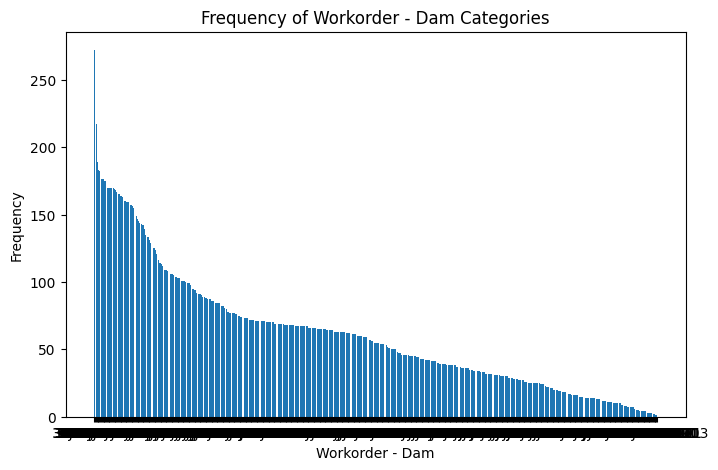

In [351]:
# 'Workorder - Dam' 컬럼의 값과 개수 계산
value_counts = df_merged['Workorder - Dam'].value_counts()

# 바 그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Workorder - Dam')
plt.ylabel('Frequency')
plt.title('Frequency of Workorder - Dam Categories')

plt.show()


### 언더 샘플링

데이타 불균형을 해결하기 위해 언더 샘플링을 진행합니다.

In [346]:
normal_ratio = 1.0  # 1.0 means 1:1 ratio

df_normal = df_merged[df_merged["target"] == "Normal"]
df_abnormal = df_merged[df_merged["target"] == "AbNormal"]

num_normal = len(df_normal)
num_abnormal = len(df_abnormal)
print(f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}")

df_normal = df_normal.sample(
    n=int(num_abnormal * normal_ratio), replace=False, random_state=RANDOM_STATE
)
df_concat = pd.concat([df_normal, df_abnormal], axis=0).reset_index(drop=True)
df_concat.value_counts("target")

  Total: Normal: 38156, AbNormal: 2350


target
AbNormal    2350
Normal      2350
Name: count, dtype: int64

### 데이터 분할

In [347]:
df_concat = df_concat.sort_values(by=["Collect Date - Dam"])
df_train, df_val = train_test_split(
    df_concat,
    test_size=0.3,
    stratify=df_concat["target"],
    random_state=RANDOM_STATE,
)


def print_stats(df: pd.DataFrame):
    num_normal = len(df[df["target"] == "Normal"])
    num_abnormal = len(df[df["target"] == "AbNormal"])

    print(
        f"  Total: Normal: {num_normal}, AbNormal: {num_abnormal}"
        + f" ratio: {num_abnormal/num_normal}"
    )


# Print statistics
print(f"  \tAbnormal\tNormal")
print_stats(df_train)
print_stats(df_val)

  	Abnormal	Normal
  Total: Normal: 1645, AbNormal: 1645 ratio: 1.0
  Total: Normal: 705, AbNormal: 705 ratio: 1.0


## 3. 모델 학습

### 모델 정의 

In [52]:
#df_merged[['Equipment - Fill1','Equipment - Fill2']]
c=0
for i,row in df_merged.iterrows():
    if row['Equipment - Fill1'][-1:]==row['Equipment - Fill2'][-1:]:
        c+=1
c


40495

#### 전처리 - 범주형 -> 수치형


In [53]:
# 라벨 인코딩
label_encoders = {}
label_encoding_columns = ['Model.Suffix - Dam','Workorder - Dam','Equipment - Fill1','Equipment - Fill2']
for column in label_encoding_columns:
    le = LabelEncoder()
    df_merged[column] = le.fit_transform(df_merged[column])
    label_encoders[column] = le

    
# 수치형 데이터 선택
df_cluster = df_merged.select_dtypes(exclude=['object'])

numeric_cols = [col for col in df_cluster.columns if col not in label_encoding_columns]

# 라벨 인코딩 하지 않은 수치형 컬럼에 대해서만 StandardScaler 적용
scaler = StandardScaler()
df_cluster[numeric_cols] = scaler.fit_transform(df_cluster[numeric_cols])
df_cluster

,Model.Suffix - Dam,Workorder - Dam,Insp. Seq No. - Dam,Collect Result - Dam,Collect Result.1 - Dam,Collect Result.2 - Dam,Collect Result.3 - Dam,Collect Result.4 - Dam,Collect Result.5 - Dam,Collect Result.6 - Dam,...,Collect Result.30 - Fill2,Collect Result.31 - Fill2,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2
0,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.202454,-1.292586,-0.680196,-0.823604,-0.598355
1,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.196969,-1.154870,-0.670688,-0.823604,-0.598355
2,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.191485,-1.843447,-0.642164,-0.823604,-0.598355
3,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.202454,-1.430301,-0.528069,-0.823604,-0.598355
4,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,-1.209471,1.209471,1.209471,-1.209471,1.209471,-1.205196,-1.154870,-0.585117,-0.823604,-0.598355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,1.441420,0.607885,-0.680196,2.457306,0.177327
40502,3,660,0.0,1.271748,1.271748,1.271748,2.677342,0.0,0.0,0.0,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,1.441420,0.635428,-0.613641,2.464954,0.177327
40503,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,1.441420,0.676743,-0.670688,2.472602,0.177327
40504,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,0.826808,-0.826808,-0.826808,0.826808,-0.826808,1.441420,0.718057,-0.661180,2.487898,0.177327


In [56]:
# K-Means 모델 생성
k=5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_cluster)
# df_cluster_scaled['Cluster'] = kmeans.labels_

print("Explained variance ratio:", pca.explained_variance_ratio_)

/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Explained variance ratio: [9.97528491e-01 6.70425233e-04]


/home/elicer/.local/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/tmp/ipykernel_55/3005644792.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=f'Cluster {i}')


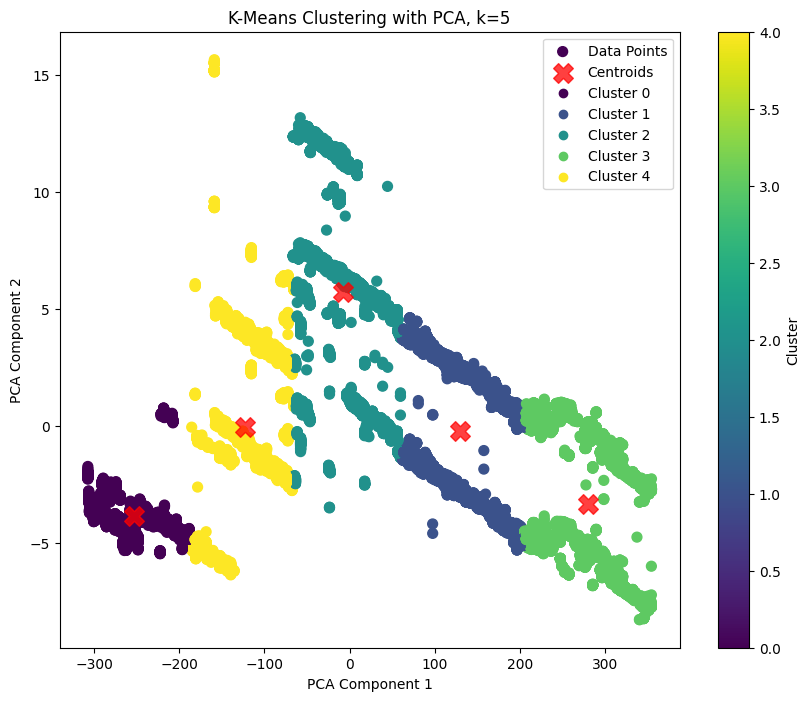

In [55]:
# 클러스터 중심과 레이블
centers = kmeans.cluster_centers_
labels = kmeans.labels_

# PCA를 사용하여 2D로 축소
pca = PCA(n_components=2)  # 2D로 축소
df_cluster_pca = pca.fit_transform(df_cluster)
centers_pca = pca.transform(centers)

# 색상 맵 및 레이블 설정
cmap = plt.get_cmap('viridis', k)  # k개의 색상
colors = [cmap(i) for i in range(k)]

# 시각화
plt.figure(figsize=(10, 8))

# 데이터 포인트 시각화
scatter = plt.scatter(df_cluster_pca[:, 0], df_cluster_pca[:, 1], c=labels, s=50, cmap='viridis', label='Data Points')

# 클러스터 중심 시각화
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')

# 클러스터 레이블 추가
for i in range(k):
    plt.scatter([], [], c=colors[i], label=f'Cluster {i}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'K-Means Clustering with PCA, k={k}')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()


In [57]:
components = pca.components_
print("Principal Components (Axis Coefficients):")
print(components)

# 주성분 설명력 (각 주성분이 데이터 분산의 얼마나 설명하는지)
explained_variance_ratio = pca.explained_variance_ratio_
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)

Principal Components (Axis Coefficients):
[[ 1.88316184e-03  9.99284692e-01 -0.00000000e+00  1.61985998e-03
   1.61985998e-03  1.61985998e-03  3.41292595e-03 -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00 -1.61985998e-03 -0.00000000e+00
   1.61985998e-03  4.58629227e-03  1.45406981e-03  3.75987463e-03
   1.39881775e-03  2.27460813e-03  3.86949233e-03  2.23698173e-03
  -1.40034552e-03  3.76002581e-03 -1.02570437e-03  1.63286403e-03
   1.78802412e-03  2.67944258e-03 -4.72202151e-03 -4.72202151e-03
   3.74418879e-03  4.47179948e-03  4.47179948e-03 -4.47179948e-03
   4.47179948e-03 -4.49430411e-03 -4.55949218e-03  4.47179948e-03
  -4.49430000e-03 -4.47179948e-03  4.46022822e-03  4.46894343e-03
   4.30360962e-03  4.52283287e-03 -3.25863736e-03  2.84853078e-03
  -4.64780932e-03 -2.53319166e-03 -2.53319166e-03 -2.53319166e-03
  -2.51196841e-03 -2.54127261e-03 -2.51196841e-03 -2.63877664e-03
  -3.72930390e-03 -4.11986612e-03 -4.11986612e-03 -4.11986612e-03
  -4.11986612e-03 -4.14984254e-03 

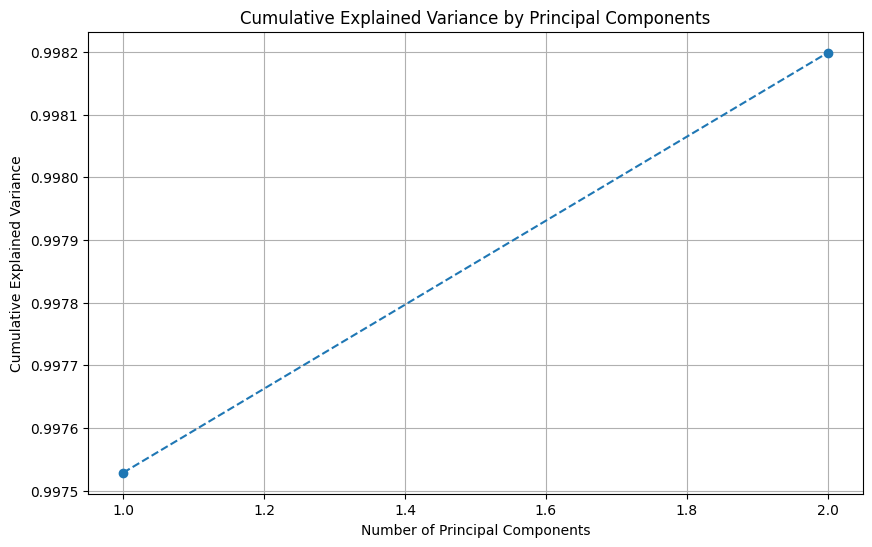

In [59]:

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# 설명력 비율 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.grid(True)
plt.show()

In [64]:

# 첫 번째 주성분의 요소
first_component = pca.components_[0]
print("First Principal Component:")
print(first_component)

# 데이터 프레임과 특성 이름
feature_names = [f'Feature {df_cluster.columns[i]}' for i in range(df_cluster.shape[1])]
df_components = pd.DataFrame(pca.components_, columns=feature_names)
print("\nPCA Components DataFrame:")


for i in df_components.columns:
    print(i,df_components.loc[0,i])

First Principal Component:
[ 1.88316184e-03  9.99284692e-01 -0.00000000e+00  1.61985998e-03
  1.61985998e-03  1.61985998e-03  3.41292595e-03 -0.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -1.61985998e-03 -0.00000000e+00
  1.61985998e-03  4.58629227e-03  1.45406981e-03  3.75987463e-03
  1.39881775e-03  2.27460813e-03  3.86949233e-03  2.23698173e-03
 -1.40034552e-03  3.76002581e-03 -1.02570437e-03  1.63286403e-03
  1.78802412e-03  2.67944258e-03 -4.72202151e-03 -4.72202151e-03
  3.74418879e-03  4.47179948e-03  4.47179948e-03 -4.47179948e-03
  4.47179948e-03 -4.49430411e-03 -4.55949218e-03  4.47179948e-03
 -4.49430000e-03 -4.47179948e-03  4.46022822e-03  4.46894343e-03
  4.30360962e-03  4.52283287e-03 -3.25863736e-03  2.84853078e-03
 -4.64780932e-03 -2.53319166e-03 -2.53319166e-03 -2.53319166e-03
 -2.51196841e-03 -2.54127261e-03 -2.51196841e-03 -2.63877664e-03
 -3.72930390e-03 -4.11986612e-03 -4.11986612e-03 -4.11986612e-03
 -4.11986612e-03 -4.14984254e-03 -4.11974901e-03 -4.15308738e-0

In [25]:
from sklearn.manifold import TSNE

# 2D로 차원 축소
tsne = TSNE(n_components=2, random_state=42) 
df_cluster_tsne = tsne.fit_transform(df_cluster)

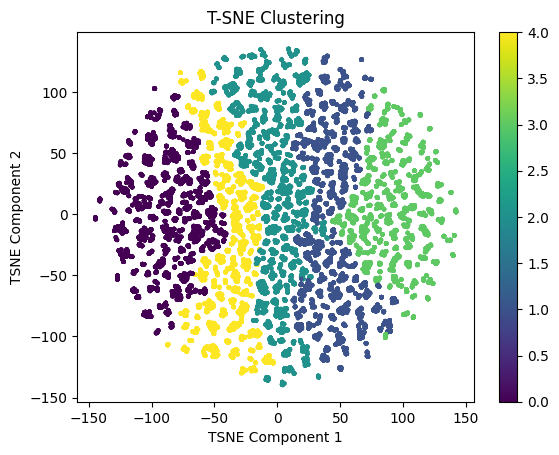

In [26]:

# 2D 시각화
plt.scatter(df_cluster_tsne[:, 0], df_cluster_tsne[:, 1], c=labels, s=5, cmap='viridis')
plt.xlabel('TSNE Component 1')
plt.ylabel('TSNE Component 2')
plt.title(f'T-SNE Clustering')
plt.colorbar()
plt.show()


In [27]:
# 엘보우 방법으로 K값 선택
inertia = []
K_range = range(1, 11)  # K 값을 1부터 10까지 시도

for K in K_range:
    kmeans = KMeans(n_clusters=K, random_state=42)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)


/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/elicer/.local/lib/python3.

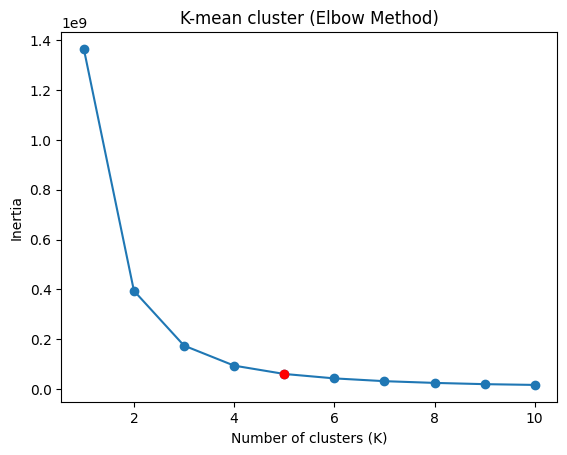

In [28]:

# 엘보우 그래프
plt.plot(K_range, inertia, marker='o')
plt.plot(K_range[4], inertia[4], marker='o',c='r')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Inertia')
plt.title('K-mean cluster (Elbow Method)')
plt.show()

In [33]:
# K-Means 모델 생성
k=5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df_cluster)
df_cluster['Cluster'] = kmeans.labels_


/home/elicer/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/tmp/ipykernel_55/3497320277.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster['Cluster'] = kmeans.labels_


In [39]:
#df_cluster['Cluster'].unique()
df_cluster['target'] = df_merged['target']
df_cluster['target']

/tmp/ipykernel_55/236914725.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_cluster['target'] = df_merged['target']


0        AbNormal
1        AbNormal
2        AbNormal
3        AbNormal
4        AbNormal
           ...   
40501      Normal
40502      Normal
40503      Normal
40504      Normal
40505      Normal
Name: target, Length: 40506, dtype: object

In [40]:
df_cluster

,Model.Suffix - Dam,Workorder - Dam,Insp. Seq No. - Dam,Collect Result - Dam,Collect Result.1 - Dam,Collect Result.2 - Dam,Collect Result.3 - Dam,Collect Result.4 - Dam,Collect Result.5 - Dam,Collect Result.6 - Dam,...,Collect Result.32 - Fill2,Collect Result.33 - Fill2,Collect Result.34 - Fill2,Collect Result.35 - Fill2,Collect Result.36 - Fill2,Collect Result.37 - Fill2,Collect Result.38 - Fill2,Collect Result.39 - Fill2,Cluster,target
0,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,1.209471,-1.209471,1.209471,-1.202454,-1.292586,-0.680196,-0.823604,-0.598355,0,AbNormal
1,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,1.209471,-1.209471,1.209471,-1.196969,-1.154870,-0.670688,-0.823604,-0.598355,0,AbNormal
2,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,1.209471,-1.209471,1.209471,-1.191485,-1.843447,-0.642164,-0.823604,-0.598355,0,AbNormal
3,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,1.209471,-1.209471,1.209471,-1.202454,-1.430301,-0.528069,-0.823604,-0.598355,0,AbNormal
4,0,0,0.0,-0.786319,-0.786319,-0.786319,-0.395838,0.0,0.0,0.0,...,1.209471,-1.209471,1.209471,-1.205196,-1.154870,-0.585117,-0.823604,-0.598355,0,AbNormal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,-0.826808,0.826808,-0.826808,1.441420,0.607885,-0.680196,2.457306,0.177327,3,Normal
40502,3,660,0.0,1.271748,1.271748,1.271748,2.677342,0.0,0.0,0.0,...,-0.826808,0.826808,-0.826808,1.441420,0.635428,-0.613641,2.464954,0.177327,3,Normal
40503,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,-0.826808,0.826808,-0.826808,1.441420,0.676743,-0.670688,2.472602,0.177327,3,Normal
40504,3,660,0.0,-0.786319,-0.786319,-0.786319,2.677342,0.0,0.0,0.0,...,-0.826808,0.826808,-0.826808,1.441420,0.718057,-0.661180,2.487898,0.177327,3,Normal


# knn으로 예측

In [31]:
# 새 값에 대해 예외 처리를 하여 인코딩하는 함수
def encode_label_with_unseen(le, value):
    try:
        return le.transform([value])[0]
    except ValueError:
        return -1  # 또는 다른 특별한 값, 예를 들어 NaN 또는 별도의 처리


In [32]:
df_test_y = pd.read_csv(os.path.join("submission.csv"))
df_test = pd.merge(X, df_test_y, "inner", on="Set ID")

df_test = df_test.drop(drop_cols, axis=1)

# Drop Lot ID
df_test = df_test.drop("LOT ID - Dam", axis=1)


# df_test 데이터프레임에 대해 인코딩 적용
for column in label_encoding_columns:
    le = label_encoders[column]
    df_test[column] = df_test[column].apply(lambda x: encode_label_with_unseen(le, x))
    
# 객체가 아닌 열만 선택하기
df_test = df_test.select_dtypes(exclude=['object'])

numeric_cols = [col for col in df_test.columns if col not in label_encoding_columns]
# 수치형 컬럼에 대해서만 StandardScaler 적용

df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])



In [33]:
# 예측된 클러스터와 상태를 별도의 DataFrame으로 생성한 후, 한 번에 병합
clusters = kmeans.predict(df_test)
status = ['Normal' if x == 3 else 'AbNormal' for x in clusters]

# 새로운 DataFrame 생성
new_columns = pd.DataFrame({'Cluster': clusters, 'Status': status})

# 기존 DataFrame과 새로운 열을 병합
df_test_y = pd.concat([df_test, new_columns], axis=1)

In [46]:
clusters

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

/tmp/ipykernel_55/451099239.py:25: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([], [], c=colors[i], label=f'Cluster {i}')


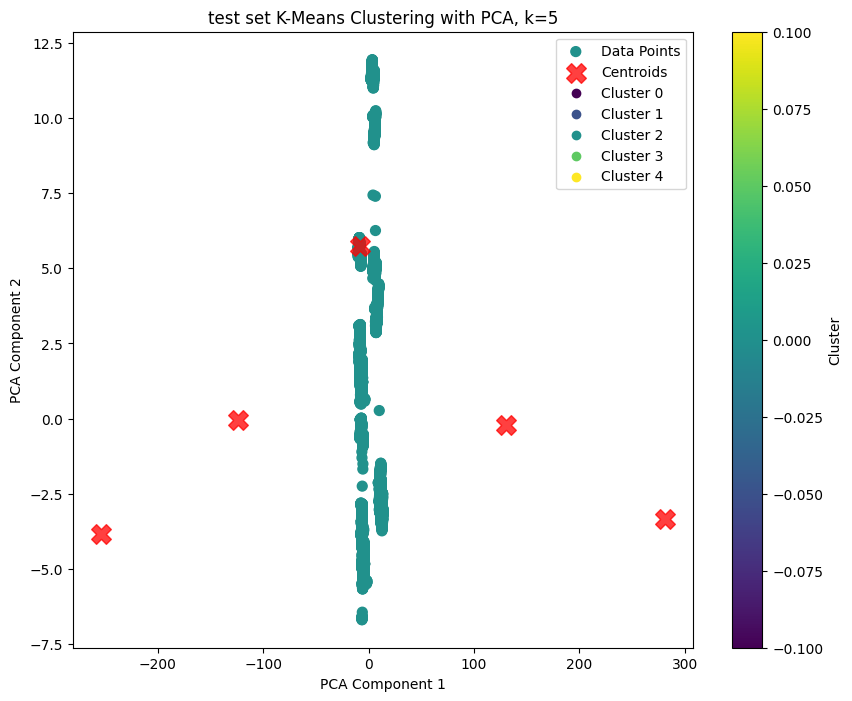

In [45]:
# 클러스터 중심과 레이블
centers = kmeans.cluster_centers_
labels = clusters

# PCA를 사용하여 2D로 축소
pca = PCA(n_components=2)  # 2D로 축소
df_test_pca = pca.fit_transform(df_test)


# 색상 맵 및 레이블 설정
cmap = plt.get_cmap('viridis', k)  # k개의 색상
colors = [cmap(i) for i in range(k)]

# 시각화
plt.figure(figsize=(10, 8))

# 데이터 포인트 시각화
scatter = plt.scatter(df_test_pca[:, 0], df_test_pca[:, 1], c=labels, s=50, cmap='viridis', label='Data Points')

# 클러스터 중심 시각화
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centroids')

# 클러스터 레이블 추가
for i in range(k):
    plt.scatter([], [], c=colors[i], label=f'Cluster {i}')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title(f'test set K-Means Clustering with PCA, k={k}')
plt.legend()
plt.colorbar(scatter, label='Cluster')
plt.show()


In [ ]:

# 예측된 클러스터와 상태를 별도의 DataFrame으로 생성한 후, 한 번에 병합
clusters = kmeans.predict(df_test)
status = ['Normal' if x == 3 else 'AbNormal' for x in clusters]

# 새로운 DataFrame 생성
new_columns = pd.DataFrame({'Cluster': clusters, 'Status': status})

# 기존 DataFrame과 새로운 열을 병합
df_test = pd.concat([df_test, new_columns], axis=1)

In [73]:
df_test_y

,Set ID,target
0,OP753345013050000002,AbNormal
1,OP753345013050000005,AbNormal
2,OP753345013050000006,AbNormal
3,OP753345013050000008,AbNormal
4,OP753345013050000009,AbNormal
...,...,...
17356,OP753345054040002683,Normal
17357,OP753345054040002685,Normal
17358,OP753345054040002686,Normal
17359,OP753345054040002687,Normal


In [72]:
df_test_y['target'] = df_test[['Status']]

df_test_y.to_csv("submission_status.csv", index=False)

In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

### 모델 학습

In [348]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

if "Set ID" in features:
    features.remove("Set ID")

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

NameError: name 'model' is not defined

## 4. 제출하기

### 테스트 데이터 예측

테스트 데이터 불러오기

In [10]:
df_test_y = pd.read_csv(os.path.join("submission.csv"))

In [11]:
df_test = pd.merge(X, df_test_y, "inner", on="Set ID")
df_test_x = df_test[features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [12]:
test_pred = model.predict(df_test_x)
test_pred

array(['AbNormal', 'AbNormal', 'AbNormal', ..., 'Normal', 'Normal',
       'Normal'], dtype=object)

### 제출 파일 작성

In [13]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**